<h1 align="center" style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">Corn and Maize Disease Detection using CNN</h1>

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">1. Import the Required Libraries</h3>

In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, F1Score

import warnings
warnings.filterwarnings('ignore')

2024-06-02 03:58:55.825553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 03:58:55.825611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 03:58:55.827060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">2. Load Dataset</h3>

In [2]:
data_dir = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'

batch_size = 32
img_height = 256
img_width = 256
seed = 123

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, # 20% of data for validation
    subset="training",
    seed=seed,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% of data for validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [5]:
# Split the validation set into validation and test sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [6]:
class_names = train_ds.class_names
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [7]:
# Prefetch data for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">3. Visualize Data</h3>

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">4. Data Normalization</h3>

In [ ]:
resize_and_rescale = tf.keras.Sequential([
tf.keras.layers.Resizing(256,256),
tf.keras.layers.Rescaling(1.0/255)
])

In [ ]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">5. Define Utility Plotting Functions</h3>

In [ ]:
def evaluate(model, data, data_type):
    # Get the true labels and the predicted labels
    y_true = np.concatenate([y for x, y in data], axis=0)
    y_pred_probs = model.predict(data)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    # Print metrics
    print(f'{data_type} Accuracy: {accuracy}')
    print(f'{data_type} Precision: {precision}')
    print(f'{data_type} Recall: {recall}')
    print(f'{data_type} F1-Score: {f1}')
    
    return accuracy, precision, recall, f1, cm

In [ ]:
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [ ]:
def plot_loss_accuracy(history, model_name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'ro-', label='train loss')
    plt.plot(val_loss, 'bo-', label='val loss')
    plt.title(f'{model_name} Training & Validation Loss', fontsize=12)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_accuracy, 'ro-', label='train accuracy')
    plt.plot(val_accuracy, 'bo-', label='val accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy', fontsize=12)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid()
    
    plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

In [ ]:
def prediction_plot(model, test_set, class_names):
    plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

    images_shown = 0
    rows = 4
    cols = 3

    for images, labels in test_set.take(1):
        for i in range(min(rows * cols, len(images))):  # Ensure we iterate over a maximum of rows*cols images
            if images_shown >= rows * cols:
                break

            ax = plt.subplot(rows, cols, images_shown + 1)  # Calculate the correct subplot index
            plt.imshow(images[i])

            predicted_class, confidence = predict(model, images[i])
            index = labels[i].argmax(axis=0)
            actual_class = class_names[index]

            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10)
            plt.axis("off")

            images_shown += 1

        if images_shown >= rows * cols:
            break

    plt.tight_layout()
    plt.show()

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:15px">6. Basic Keras Model</h3>

In [ ]:
num_classes = len(class_names)
input_shape = (img_height, img_width, 3)
epoch = 15

In [ ]:
model = Sequential([
    layers.Conv2D(32,(3,3),activation ='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch
)

105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5798 - loss: 0.8309 - val_accuracy: 0.7601 - val_loss: 0.8228
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5977 - loss: 0.8439 - val_accuracy: 0.6675 - val_loss: 0.8478
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7776 - loss: 0.5622 - val_accuracy: 0.8219 - val_loss: 0.3723
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8539 - loss: 0.3588 - val_accuracy: 0.8100 - val_loss: 0.4136
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8717 - loss: 0.3251 - val_accuracy: 0.8551 - val_loss: 0.3170
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8686 - loss: 0.3159 - val_accuracy: 0.8670 - val_loss: 0.2977
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8826 - loss: 0.2684 - val_accuracy: 0.8670 - val_loss: 0.2927
Epoch 9/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8861 - loss: 0.2641 - val_accuracy: 0.86

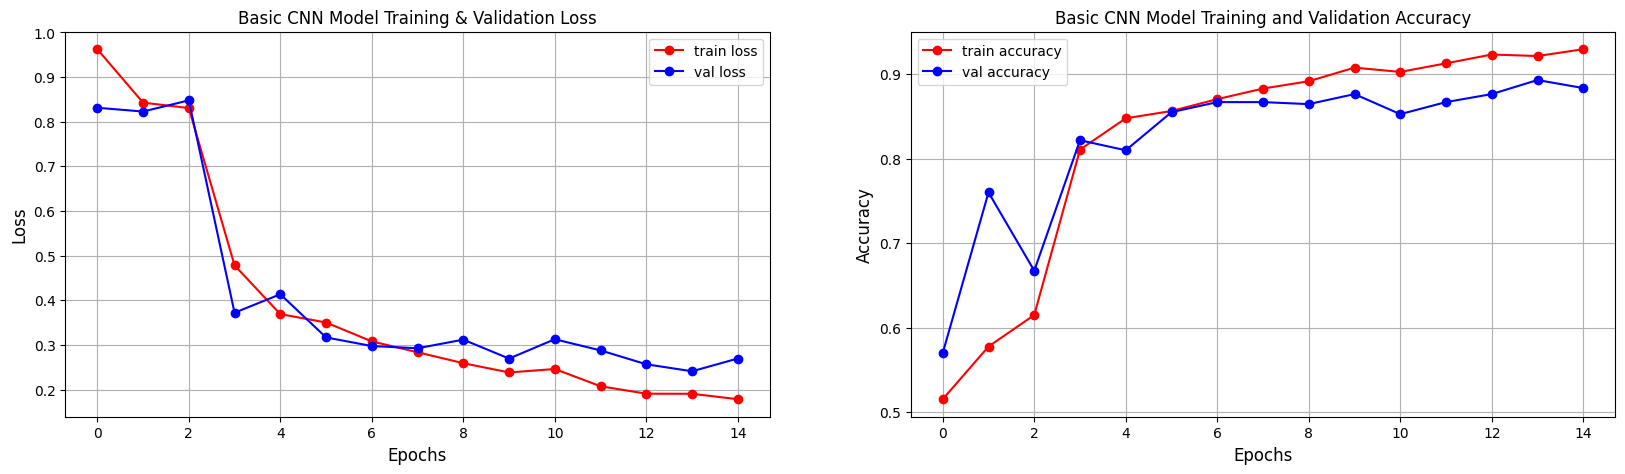

In [21]:
plot_loss_accuracy(history, 'Basic CNN Model')

In [22]:
accuracy, precision, recall, f1, cm = evaluate(model, val_ds, data_type='Validation')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Validation Accuracy: 0.8836104513064132
Validation Precision: 0.8897722584679292
Validation Recall: 0.8836104513064132
Validation F1-Score: 0.8861564424553559


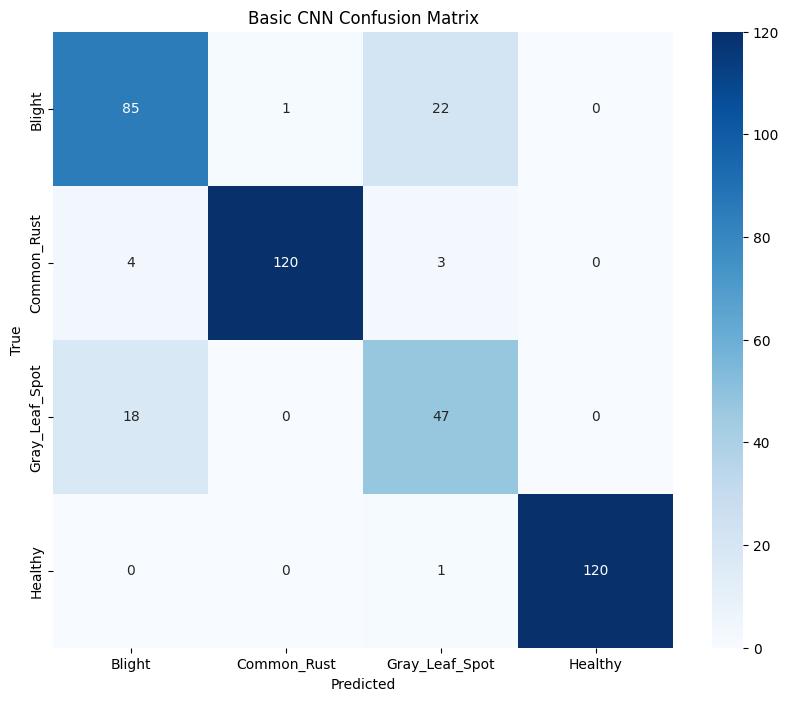

In [23]:
# Plot confusion matrix
plot_confusion_matrix(cm, class_names, model_name='Basic CNN')
plt.show()

In [24]:
def prediction_plot(model, test_set, class_names):
    plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

    images_shown = 0
    rows = 4
    cols = 3

    for images, labels in test_set.take(1):
        for i in range(min(rows * cols, len(images))):  # Ensure we iterate over a maximum of rows*cols images
            if images_shown >= rows * cols:
                break

            ax = plt.subplot(rows, cols, images_shown + 1)  # Calculate the correct subplot index
            plt.imshow(images[i])

            predicted_class, confidence = predict(model, images[i])
#             index = labels[i].max(axis=0)
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10)
            plt.axis("off")

            images_shown += 1

        if images_shown >= rows * cols:
            break

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


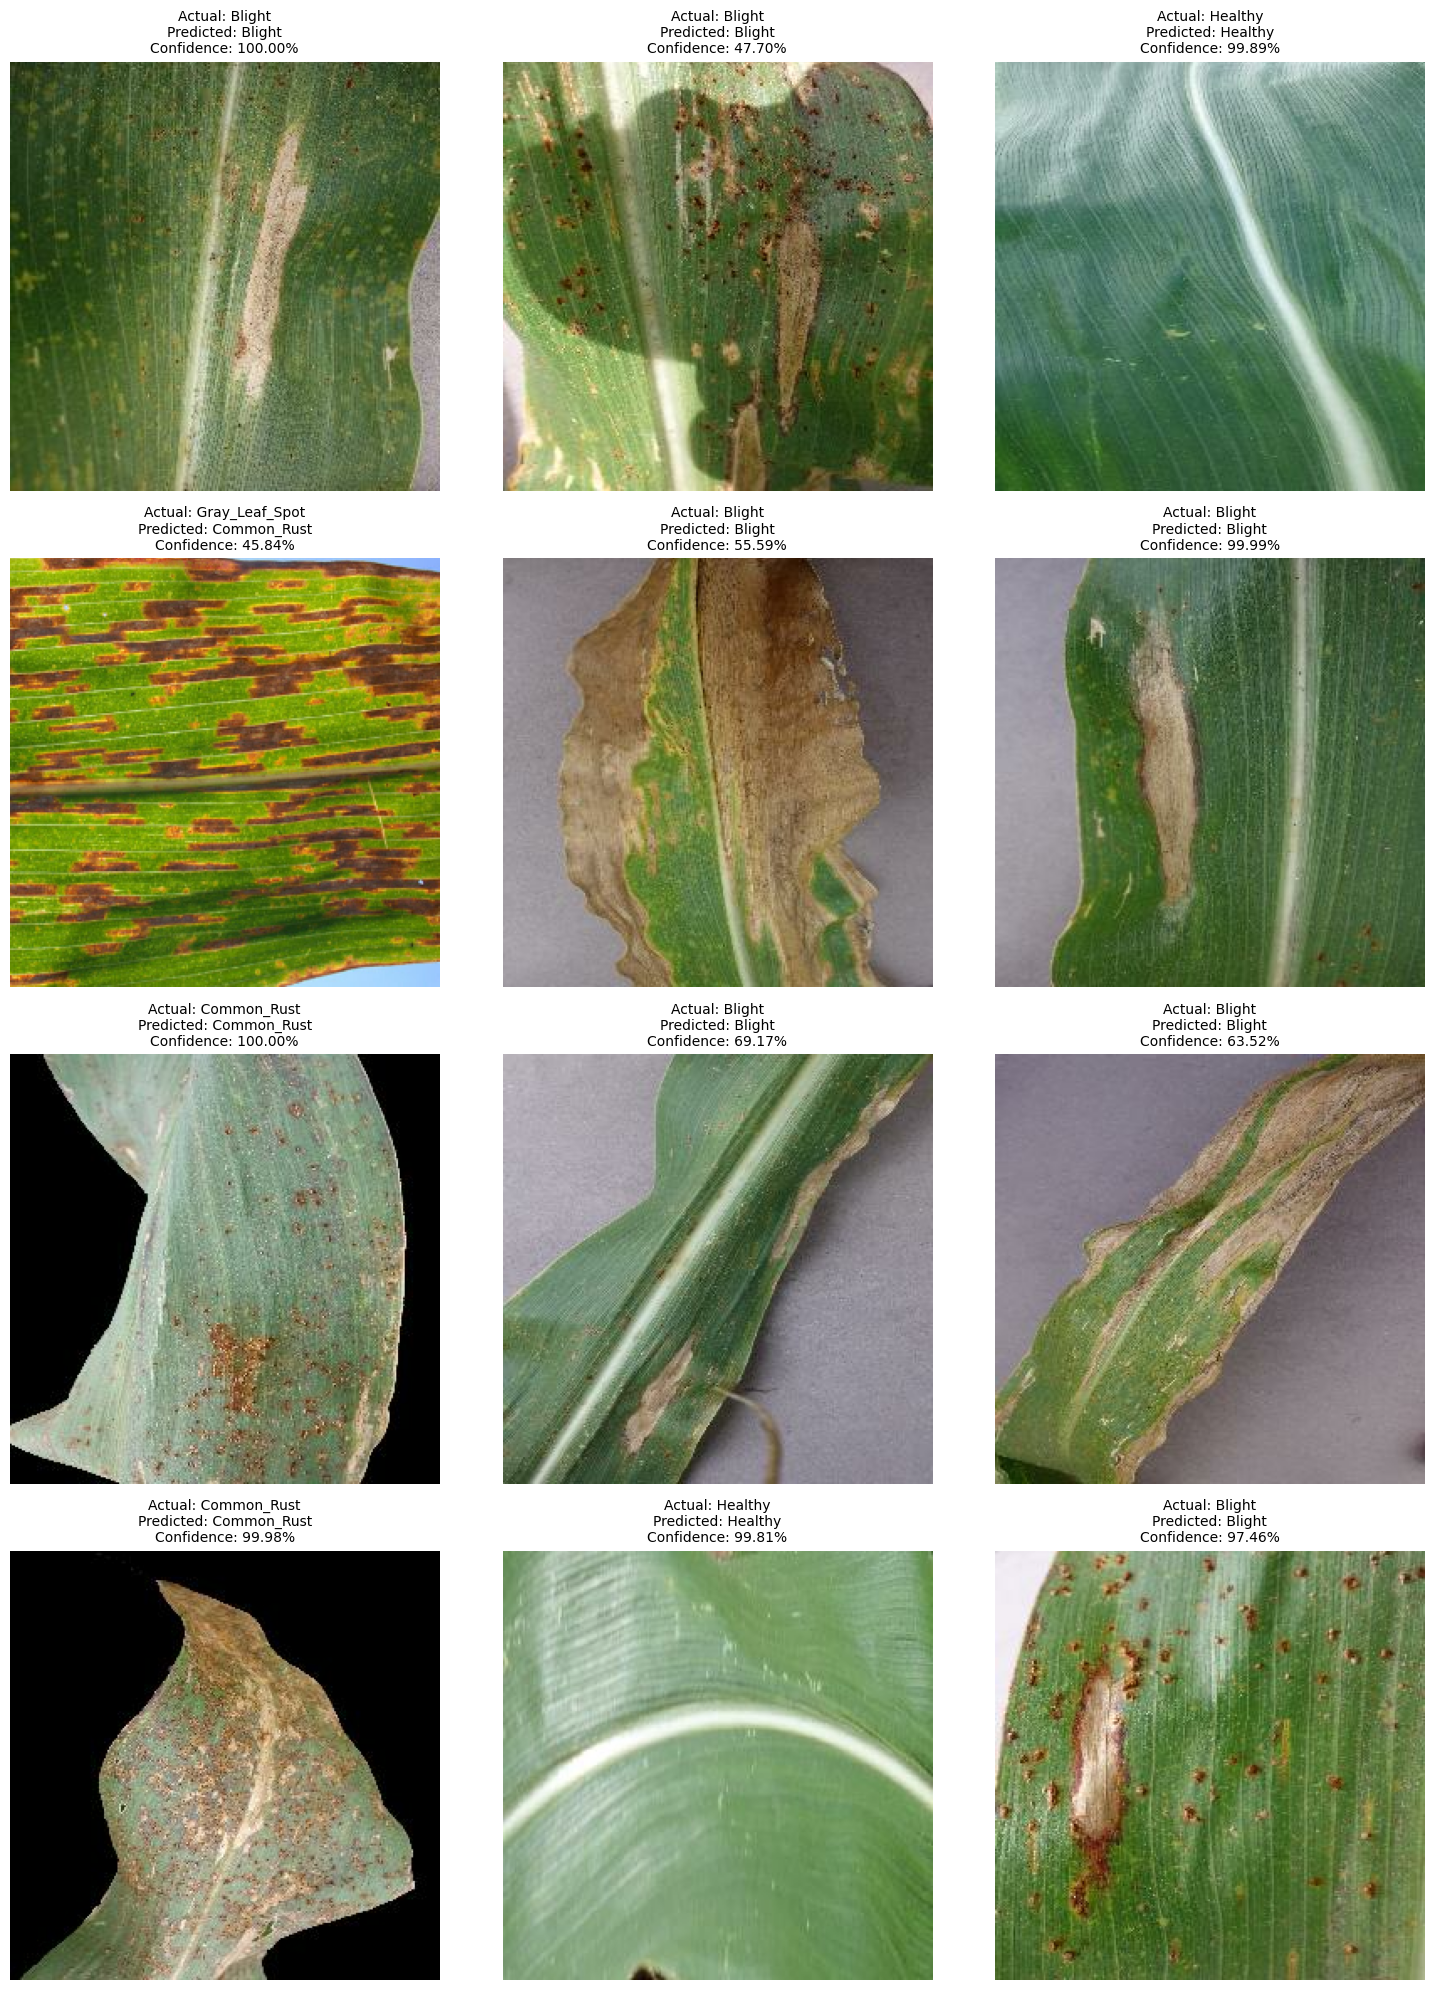

In [25]:
prediction_plot(model, test_ds, class_names)

In [26]:
accuracy, precision, recall, f1, cm = evaluate(model, test_ds, data_type='Test')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test Accuracy: 0.8990384615384616
Test Precision: 0.9114176423221808
Test Recall: 0.8990384615384616
Test F1-Score: 0.9031100795220018
